# Test Re-test analysis

In [26]:
#Import python notebooks
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy
import scipy.io as sio
import os
import glob
from scipy.stats import norm
import math
# import arviz as az
# import pymc3 as pm
import pandas as pd
from datetime import datetime, timedelta
plt.rcParams.update({'font.size': 16})

## Load the data

In [27]:
#Change the directory
os.chdir('C:\\Users\\Jonathan\\Documents\\GitHub\\Split-Belt-AFC-Reliability\\Data\\TestRetest_PSI')

#Load the data
File_names = glob.glob("*.mat")

print('Files:')

Combined_data = []
for i, f in enumerate(File_names):
    Current_Subject = f[:-9]
    print(f)
    
    D = sio.loadmat(f)
    
    #Change these to 1d instead of 2
    D['AllResponses'] = D['AllResponses'][0]
    D['AllStarts'] = D['AllStarts'][0]
    D['AllStims'] = D['AllStims'][0]
    D['BinaryResponses'] = D['BinaryResponses'][0]
    D['alpha_EV'] = D['alpha_EV'][0]
    D['beta_EV'] = D['beta_EV'][0]

    #Trial Length
    Ntrials = len(D['BinaryResponses'])
    
    #Baseline difference
    D['BslDiff'] = np.ones_like(D['BinaryResponses'])*D['BslDiff'][0]
    #Subject ID and test number
    D['SID'] = [Current_Subject[:-1]]*Ntrials
    D['Test'] = [Current_Subject[-1]]*Ntrials
    
    #Start and end date time
    Test_Start = D.pop('PhaseStart')
    PhaseStart = datetime.strptime(Test_Start[0], "%d-%b-%Y %H:%M:%S")
    Test_Length = timedelta(seconds=D.pop('elapsedTime')[0][0])
    PhaseEnd = PhaseStart+Test_Length
    D['StartTime'] = [PhaseStart]*Ntrials
    D['EndTime'] = [PhaseEnd]*Ntrials
    
    #Delete the unnecessary keys
    del D['__header__'], D['__version__'], D['__globals__']
    
    #Create dataframe 
    currentDF = pd.DataFrame.from_dict(D)
    Combined_data.append(currentDF)
DF = pd.concat(Combined_data)

Files:
PSItest_08a_data.mat
PSItest_08b_data.mat
PSItest_09a_data.mat
PSItest_09b_data.mat
PSItest_10a_data.mat
PSItest_10b_data.mat
PSItest_11a_data.mat
PSItest_11b_data.mat
PSItest_12a_data.mat
PSItest_12b_data.mat


## Index Start positions and Test length

PSItest_08 a - Start Positions Equal (Top-Down= 25 ; Bottom-Up= 25 )
PSItest_08 b - Start Positions Equal (Top-Down= 25 ; Bottom-Up= 25 )
PSItest_09 a - Start Positions Equal (Top-Down= 25 ; Bottom-Up= 25 )
PSItest_09 b - Start Positions Equal (Top-Down= 25 ; Bottom-Up= 25 )
PSItest_10 a - Start Positions Equal (Top-Down= 25 ; Bottom-Up= 25 )
PSItest_10 b - Start Positions Equal (Top-Down= 25 ; Bottom-Up= 25 )
PSItest_11 a - Start Positions Equal (Top-Down= 25 ; Bottom-Up= 25 )
PSItest_11 b - Start Positions Equal (Top-Down= 25 ; Bottom-Up= 25 )
PSItest_12 a - Start Positions Equal (Top-Down= 25 ; Bottom-Up= 25 )
PSItest_12 b - Start Positions Equal (Top-Down= 25 ; Bottom-Up= 25 )


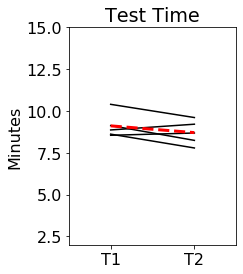

In [28]:
SIDs = pd.unique(DF.SID)
TNs = pd.unique(DF.Test)
Time = []
for i in range(len(SIDs)):
    
    T1 = DF.EndTime[(DF.SID==SIDs[i]) & (DF.Test=='a')][0] - DF.StartTime[(DF.SID==SIDs[i]) & (DF.Test=='a')][0]
    T2 = DF.EndTime[(DF.SID==SIDs[i]) & (DF.Test=='b')][0] - DF.StartTime[(DF.SID==SIDs[i]) & (DF.Test=='b')][0]
    Time.append([T1.total_seconds(), T2.total_seconds()])

    for t in range(len(TNs)):
        
        Starts = DF.AllStarts[(DF.SID==SIDs[i]) & (DF.Test==TNs[t])]
        Stims = DF.AllStims[(DF.SID==SIDs[i]) & (DF.Test==TNs[t])]
                
        TD = Starts > Stims 
        BU = Starts < Stims
        if sum(TD) == sum(BU):
            print(SIDs[i],  TNs[t], '- Start Positions Equal (Top-Down=', str(sum(TD)), '; Bottom-Up=', str(sum(BU)), ')')
        elif sum(TD) != sum(BU):
            print(SIDs[i],  TNs[t], '- Start Positions Unequal (Top-Down=', str(sum(TD)), '; Bottom-Up=', str(sum(BU)), ')')
    
Time = np.array(Time)    
Time = Time/60

#Plot
plt.figure(figsize=(3,4))
plt.plot([np.ones(len(Time)), np.ones(len(Time))*2], [Time[:,0], Time[:,1]] ,'k-')
plt.plot([1, 2],[np.mean(Time[:,0]), np.mean(Time[:,1])],'r--',lw=3)
plt.xlim(0.5, 2.5)
plt.ylim(2, 15)
plt.xticks([1,2],['T1', 'T2'])
plt.title('Test Time')
plt.ylabel('Minutes')
plt.show()

## Visualize each trial

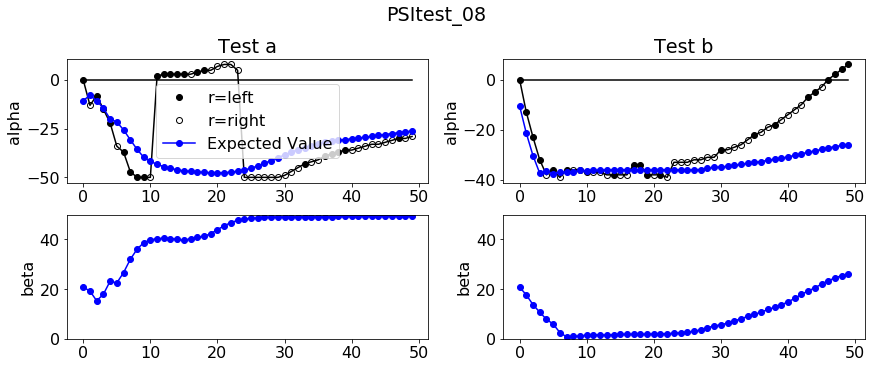

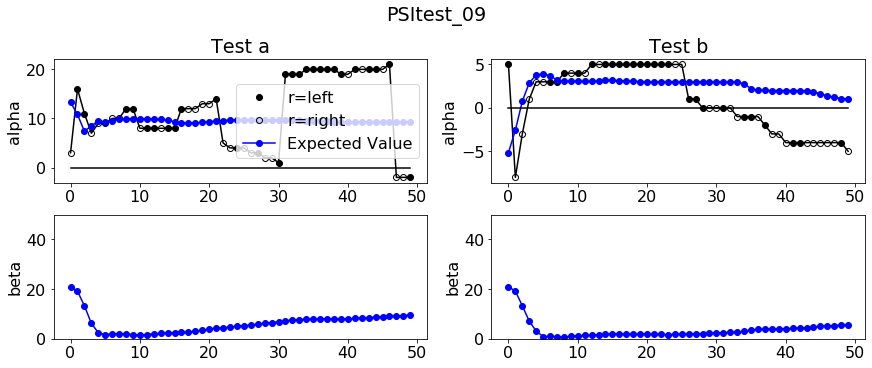

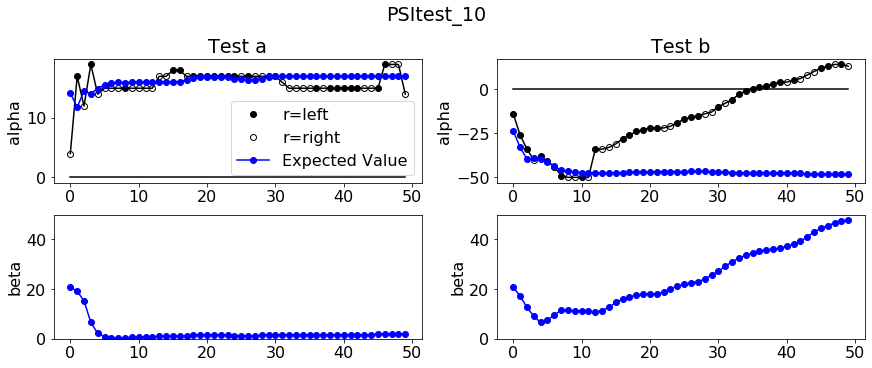

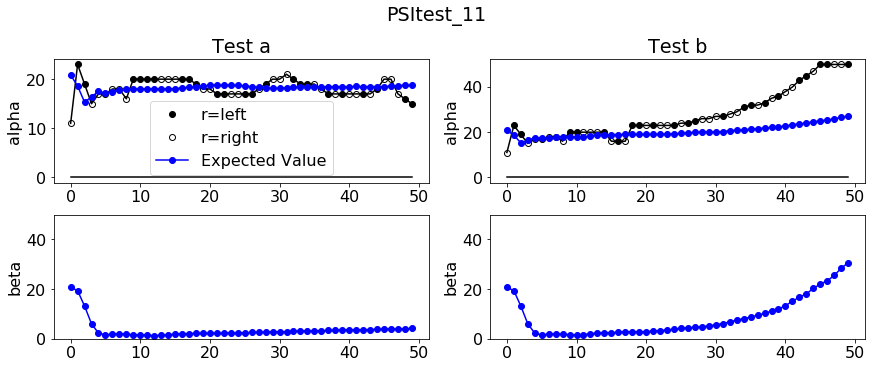

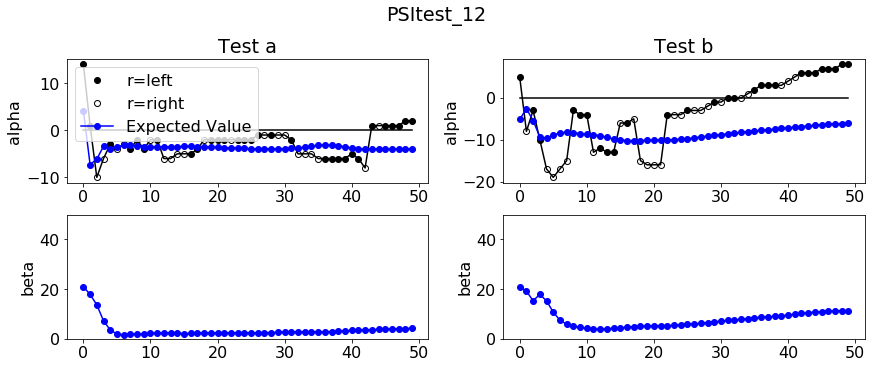

In [30]:
SIDs = pd.unique(DF.SID)
TNs = pd.unique(DF.Test)

for i in range(len(SIDs)):
    fig, ax = plt.subplots(2, 2, constrained_layout=True, figsize=(12,5))
    
    for t in range(len(TNs)):
        BslDiff = round(DF.BslDiff[(DF.SID==SIDs[i]) & (DF.Test==TNs[t])].values[0])

        Stims = np.array(DF.AllStims[(DF.SID==SIDs[i]) & (DF.Test==TNs[t])]+BslDiff)
        aEV = DF.alpha_EV[(DF.SID==SIDs[i]) & (DF.Test==TNs[t])]+BslDiff
        bEV = DF.beta_EV[(DF.SID==SIDs[i]) & (DF.Test==TNs[t])]

        Responses = DF.BinaryResponses[(DF.SID==SIDs[i]) & (DF.Test==TNs[t])]
        L_response = np.argwhere(Responses==1)
        R_response = np.argwhere(Responses==0)
                                 
        ax[0,t].plot(Stims,'k-')
        ax[0,t].plot(L_response,Stims[L_response],'ko-', linestyle='none', label='r=left')
        ax[0,t].plot(R_response,Stims[R_response],'ko-', linestyle='none', fillstyle='none',label='r=right')
        ax[0,t].plot(aEV,'bo-', label='Expected Value')
        ax[0,t].plot(np.zeros(len(Stims)),'k-')
        ax[0,t].set(ylabel='alpha',title='Test '+ TNs[t])
        if t == 0:
            ax[0,t].legend()
        
        ax[1,t].plot(bEV,'bo-')
        ax[1,t].set(ylim=(0,50),ylabel='beta')
    
    fig.suptitle(SIDs[i])

## Visually compare the two psychometric functions 


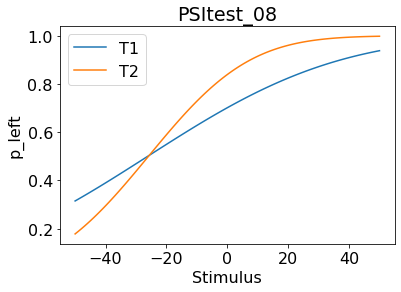

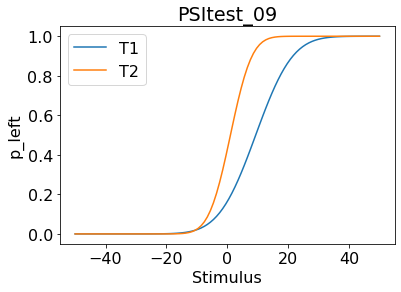

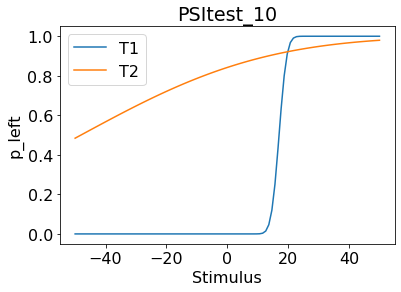

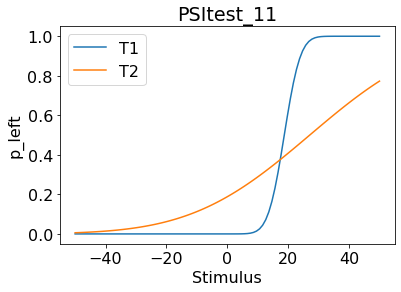

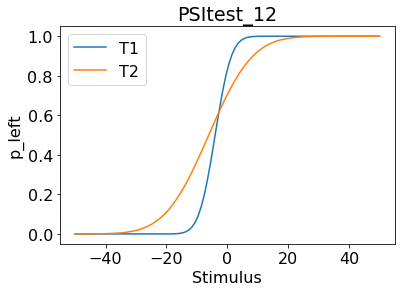

In [31]:
SIDs = pd.unique(DF.SID)
x = np.linspace(-50,50,100) #X-axis 

#initialize for parameters
alphas = []
betas = []
for i in range(len(SIDs)):
    fig, ax = plt.subplots()

    #Index baseline difference
    BD_a = round(DF.BslDiff[(DF.SID==SIDs[i]) & (DF.Test=='a')].values[0])
    BD_b = round(DF.BslDiff[(DF.SID==SIDs[i]) & (DF.Test=='b')].values[0])

    #index estimates for test 1 and 2
    aEV_a = DF.alpha_EV[(DF.SID==SIDs[i]) & (DF.Test=='a')].values[-1] + BD_a
    bEV_a = DF.beta_EV[(DF.SID==SIDs[i]) & (DF.Test=='a')].values[-1]

    aEV_b = DF.alpha_EV[(DF.SID==SIDs[i]) & (DF.Test=='b')].values[-1] + BD_b
    bEV_b = DF.beta_EV[(DF.SID==SIDs[i]) & (DF.Test=='b')].values[-1]

    #Store the estimates
    alphas.append([aEV_a, aEV_b])
    betas.append([bEV_a, bEV_b])
    
    #Calculate the psychometric functions
    psi_a = norm.cdf(x,aEV_a,bEV_a)
    psi_b = norm.cdf(x,aEV_b,bEV_b)

    #Plot
    ax.plot(x,psi_a,label='T1')
    ax.plot(x,psi_b,label='T2')
    ax.legend()
    ax.set(title=SIDs[i],ylabel='p_left',xlabel='Stimulus')    
    plt.show() 
    
alphas = np.array(alphas)
betas = np.array(betas)

## Compare the parameters

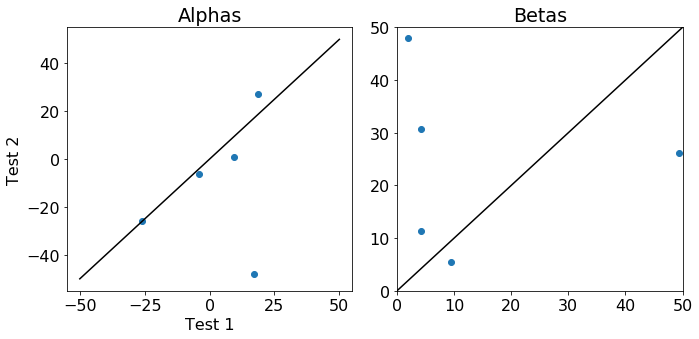

In [32]:
#Calculate CCC


#Plot the parameters
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(alphas[:,0],alphas[:,1],'o')
plt.plot(x,x,'k')
plt.title('Alphas')
plt.xlabel('Test 1')
plt.ylabel('Test 2')

plt.subplot(1,2,2)
plt.plot(betas[:,0],betas[:,1],'o')
plt.plot(x,x,'k')
plt.title('Betas')
plt.ylim(0, 50)
plt.xlim(0, 50)

plt.tight_layout()
plt.show()


## Fit the actual data as a spot check

In [23]:
import scipy.optimize as opt

def nloglik(params,X,N,K):
    '''
    This function returns the negative log likelihood of the parameters mu and sigma 
    for a data set 
    X = stimuli (vector)
    N = number of trials at each X 
    K = Number of trials with the response of interest
    '''   
    alpha=params[0]
    beta=params[1]
    
    phi = norm.cdf(X,alpha,beta)       
    ll = np.sum(K * np.log(phi) + ((N - K) * np.log(1-phi)))

    nll = -ll
    
    return nll

45
Optimization terminated successfully.
         Current function value: 64.721318
         Iterations: 59
         Function evaluations: 121
24
Optimization terminated successfully.
         Current function value: 64.222025
         Iterations: 69
         Function evaluations: 134
40
Optimization terminated successfully.
         Current function value: 69.134610
         Iterations: 162
         Function evaluations: 408
26
Optimization terminated successfully.
         Current function value: 68.753459
         Iterations: 74
         Function evaluations: 152
27
Optimization terminated successfully.
         Current function value: 61.990932
         Iterations: 81
         Function evaluations: 155


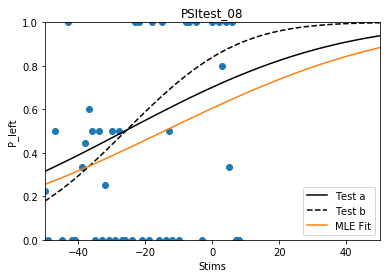

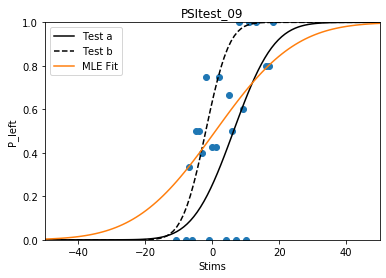

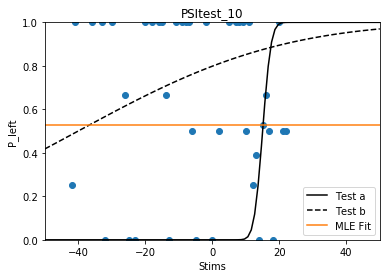

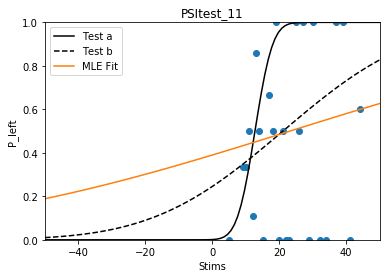

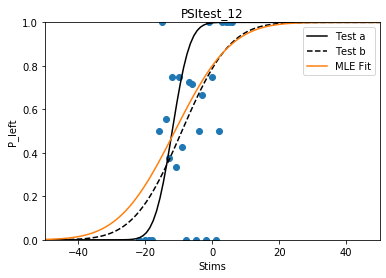

In [24]:
SIDs = pd.unique(DF.SID)
x = np.linspace(-50,50,100) #X-axis 

#initialize parameters
alphas = []
betas = []
for i in range(len(SIDs)):
    fig, ax = plt.subplots()

    #index estimates for test 1 and 2
    aEV_a = DF.alpha_EV[(DF.SID==SIDs[i]) & (DF.Test=='a')].values[-1] 
    bEV_a = DF.beta_EV[(DF.SID==SIDs[i]) & (DF.Test=='a')].values[-1]

    aEV_b = DF.alpha_EV[(DF.SID==SIDs[i]) & (DF.Test=='b')].values[-1]
    bEV_b = DF.beta_EV[(DF.SID==SIDs[i]) & (DF.Test=='b')].values[-1]

    #Calculate the psychometric functions
    psi_a = norm.cdf(x,aEV_a,bEV_a)
    psi_b = norm.cdf(x,aEV_b,bEV_b)   
    
    #Index the responses
    Responses =np.array(DF.BinaryResponses[(DF.SID==SIDs[i])])
    
    #Index baseline difference
    BD_a = round(DF.BslDiff[(DF.SID==SIDs[i]) & (DF.Test=='a')].values[0])
    BD_b = round(DF.BslDiff[(DF.SID==SIDs[i]) & (DF.Test=='b')].values[0])
    
    #Index the stimuli
    Stims_a = DF.AllStims[(DF.SID==SIDs[i]) & (DF.Test=='a')] 
    Stims_b = DF.AllStims[(DF.SID==SIDs[i]) & (DF.Test=='b')]
    
    Stims = np.concatenate((Stims_a,Stims_b))

    #Control for repeated stimuli 
    Unique_stims, stim_idx = np.unique(Stims, return_index=True)
    Unique_stims = Stims[np.sort(stim_idx)]
    Nstims = np.empty(len(Unique_stims))
    Kleft = np.empty(len(Unique_stims))
    for u, s in enumerate(Unique_stims):
        stim_idx = np.argwhere(s==Stims)
        stim_idx = stim_idx[:,0]
        Nstims[u] = len(stim_idx)
        Kleft[u] = np.sum(Responses[stim_idx])  
        
    P_left = Kleft / Nstims 
    print(len(Unique_stims))
    minimum = opt.fmin(nloglik, x0=[np.random.randint(-50,50),np.random.randint(1,50)], 
                       args = (Unique_stims,Nstims,Kleft),
                      full_output=True, maxfun=1e6, xtol=1e-6
                      )
    params = minimum[0]
    fit_alpha = params[0]
    fit_beta = params[1]
    psi_fit = norm.cdf(x,fit_alpha,fit_beta)
    
    ax.plot(Unique_stims,P_left,'ko')
    ax.plot(x,psi_a,'k-',label='Test a')
    ax.plot(x,psi_b,'k--',label='Test b')
    ax.plot(x,psi_fit,label='MLE Fit')
    ax.set(xlim=(-50,50),ylim=(0,1),title=SIDs[i],xlabel='Stims',ylabel='P_left')
    ax.legend()